In [384]:
import numpy as np      
import pandas as pd 
from pandas.plotting import autocorrelation_plot as auto_corr

import matplotlib.pyplot as plt  
%matplotlib inline    
import matplotlib as mpl
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


import math
from datetime import datetime
from datetime import timedelta

In [385]:
pd.options.display.max_columns=100 # to see columns 
df = pd.read_feather('store_data.feather')
df.head()

,date,store_no,region,city,postal,street,longitude,latitude,store_area,location_type,turnover,population,competitor_count,footfall,avg_temperature,min_temperature,max_temperature,precipitation_mm,snow_depth_mm,wind_direction_degrees,wind_speed_kmh,peak_wind_gust_kmh,air_pressure_hpa
7267,2021-02-12,2335,Bayern,Lauf,91207,Marktplatz 15,11.281178,49.511979,449.0,Fußgängerzone,0.00000,2699,3,NaN,-10.9,-18.0,-2.8,0.0,130.0,79.0,14.2,35.3,1033.1
14061,2021-03-01,197,Rheinland-pfalz,Bitburg,54634,Trierer Str.19,6.523312,49.970275,263.0,Hauptgeschaeftsstrasse,7.58898,1215,5,NaN,6.6,0.5,14.0,0.0,NaN,73.0,13.1,NaN,1032.6
14064,2021-03-01,441,Rheinland-pfalz,Annweiler,76855,Hauptstr. 35,7.963420,49.202622,350.0,Hauptgeschaeftsstrasse,35.17698,766,2,NaN,7.4,2.4,12.8,0.0,0.0,45.0,12.5,NaN,1032.5
14068,2021-03-01,632,Saarland,Lebach,66822,Am Markt 6,6.906569,49.411052,363.0,Fußgängerzone,29.42340,2397,4,3.0,5.8,0.6,12.1,0.0,0.0,74.0,13.9,41.4,1032.0
14075,2021-03-01,1218,Rheinland-pfalz,Traben-Trarbach,56841,Poststr. 1 A,7.116635,49.950358,354.0,Hauptgeschaeftsstrasse,28.85454,645,1,3.0,5.5,0.3,12.4,0.0,0.0,51.0,11.2,40.3,1033.0


In [386]:
df['store_no'].nunique()

500

In [387]:
df['week'] = df['date'].dt.isocalendar().week  
df['year'] = df['date'].dt.year 

df['weekly_turnover_mean'] = df.groupby(['year', 'week'])['turnover'].transform('mean')

In [388]:
df.loc[df['weekly_turnover_mean']<=0]


,date,store_no,region,city,postal,street,longitude,latitude,store_area,location_type,turnover,population,competitor_count,footfall,avg_temperature,min_temperature,max_temperature,precipitation_mm,snow_depth_mm,wind_direction_degrees,wind_speed_kmh,peak_wind_gust_kmh,air_pressure_hpa,week,year,weekly_turnover_mean
7267,2021-02-12,2335,Bayern,Lauf,91207,Marktplatz 15,11.281178,49.511979,449.0,Fußgängerzone,0.0,2699,3,NaN,-10.9,-18.0,-2.8,0.0,130.0,79.0,14.2,35.3,1033.1,6,2021,0.0


In [389]:
df = df.loc[df['weekly_turnover_mean'] > 0]
df.shape #(414644, 26)

(414644, 26)

In [390]:
df['date'].head(5)
#  In dataset, beginning of the date is 2021-03-01


14061   2021-03-01
14064   2021-03-01
14068   2021-03-01
14075   2021-03-01
14076   2021-03-01
Name: date, dtype: datetime64[ns]

In [391]:
df['date'].tail(5)
#  In dataset, end of the date is 2023-12-30


1652267   2023-12-30
1652270   2023-12-30
1652271   2023-12-30
1652272   2023-12-30
1652273   2023-12-30
Name: date, dtype: datetime64[ns]

In [392]:
print(df['store_no'].unique())
df.describe() # to see weird statistical things


[ 197  441  632 1218 1222 1227 1251 1351 1357 1445 1537 1768 1772 1777
 1865 1882 1927 1930 1984 2074 2108 2316 2410 2750 2773 2877 5406 5407
 5441 1148   13   42  102  110  123  132  144  146  160  199  214  227
  254  303  314  317  323  331  347  367  416  544  647  683  702  708
  715  751  760  787  844  879  966  973  977  989 1025 1044 1045 1058
 1060 1094 1097 1109 1112 1114 1132 1165 1245 1246 1255 1274 1322 1330
 1363 1378 1395 1407 1409 1413 1420 1428 1431 1432 1440 1441 1446 1466
 1471 1480 1487 1493 1497 1538 1551 1559 1561 1563 1586 1599 1601 1604
 1610 1614 1618 1634 1643 1644 1648 1649 1653 1666 1680 1685 1690 1713
 1716 1717 1719 1721 1726 1731 1747 1756 1757 1758 1759 1767 1771 1779
 1791 1795 1799 1804 1808 1839 1842 1845 1846 1856 1857 1864 1875 1877
 1878 1879 1880 1898 1906 1907 1910 1912 1923 1945 1946 1948 1952 1957
 1959 1973 1982 1987 1994 2003 2014 2019 2026 2028 2039 2046 2050 2053
 2055 2057 2058 2070 2071 2077 2080 2081 2082 2084 2091 2093 2094 2096
 2103 

,date,store_no,longitude,latitude,store_area,turnover,population,competitor_count,footfall,avg_temperature,min_temperature,max_temperature,precipitation_mm,snow_depth_mm,wind_direction_degrees,wind_speed_kmh,peak_wind_gust_kmh,air_pressure_hpa,week,year,weekly_turnover_mean
count,414644,414644.000000,414644.000000,414644.000000,414644.000000,414644.000000,414644.000000,414644.000000,245532.000000,414642.000000,414641.000000,414641.000000,414642.000000,317240.000000,414585.000000,414633.000000,335024.000000,414631.000000,414644.0,414644.000000,414644.000000
mean,2022-08-19 06:41:15.453641728,2526.422309,10.095761,50.482001,394.537790,135.106136,1966.425293,2.309043,20.048747,11.043130,6.637463,15.536661,2.231798,3.705337,194.956455,11.920107,35.554252,1016.726916,28.210077,2022.096900,135.106136
min,2021-03-01 00:00:00,13.000000,6.128864,47.441837,155.000000,-4.101720,159.000000,0.000000,2.000000,-12.300000,-19.000000,-9.100000,0.000000,0.000000,0.000000,0.000000,0.000000,975.800000,1.0,2021.000000,43.566768
25%,2021-12-13 00:00:00,1649.000000,8.487007,49.307972,336.000000,97.487100,884.000000,1.000000,14.000000,5.500000,1.700000,8.700000,0.000000,0.000000,124.000000,7.600000,25.200000,1011.800000,16.0,2021.000000,115.735391
50%,2022-08-20 00:00:00,2127.000000,9.919610,50.475569,385.000000,129.456690,1414.000000,2.000000,19.000000,11.000000,6.900000,15.600000,0.100000,0.000000,217.000000,10.700000,32.800000,1017.200000,29.0,2022.000000,135.362688
75%,2023-04-25 00:00:00,2741.000000,11.774459,51.508459,444.000000,165.894225,2363.000000,4.000000,25.000000,17.000000,11.800000,22.300000,2.300000,0.000000,260.000000,14.800000,42.800000,1022.100000,41.0,2023.000000,152.843205
max,2023-12-30 00:00:00,5527.000000,14.964019,54.516223,835.000000,1514.451240,23838.000000,6.000000,205.000000,30.600000,23.900000,40.100000,167.600000,870.000000,360.000000,73.300000,142.000000,1047.300000,52.0,2023.000000,220.737133
std,NaN,1488.220537,2.012017,1.547162,91.053709,56.117603,2095.501401,1.866074,9.295912,7.128169,6.308904,8.478547,4.904838,26.123153,91.218298,5.830933,14.676694,8.885506,14.467751,0.789794,30.530053


In [393]:
print(df['date'].isna().sum())


0


In [394]:
print(df['turnover'].describe())  
print(df['turnover'].isna().sum())  

count    414644.000000
mean        135.106136
std          56.117603
min          -4.101720
25%          97.487100
50%         129.456690
75%         165.894225
max        1514.451240
Name: turnover, dtype: float64
0


In [395]:
df['weekly_turnover_mean'] = df.groupby(['year', 'week', 'store_no'])['turnover'].transform('mean')


In [396]:
print(df['week'])
print("------")
print(df['weekly_turnover_mean'])


14061       9
14064       9
14068       9
14075       9
14076       9
           ..
1652267    52
1652270    52
1652271    52
1652272    52
1652273    52
Name: week, Length: 414644, dtype: UInt32
------
14061       24.651740
14064       34.563850
14068       30.230330
14075       28.556810
14076       38.673170
              ...    
1652267    126.056640
1652270    163.588005
1652271     83.709915
1652272    127.305795
1652273    140.589075
Name: weekly_turnover_mean, Length: 414644, dtype: float64


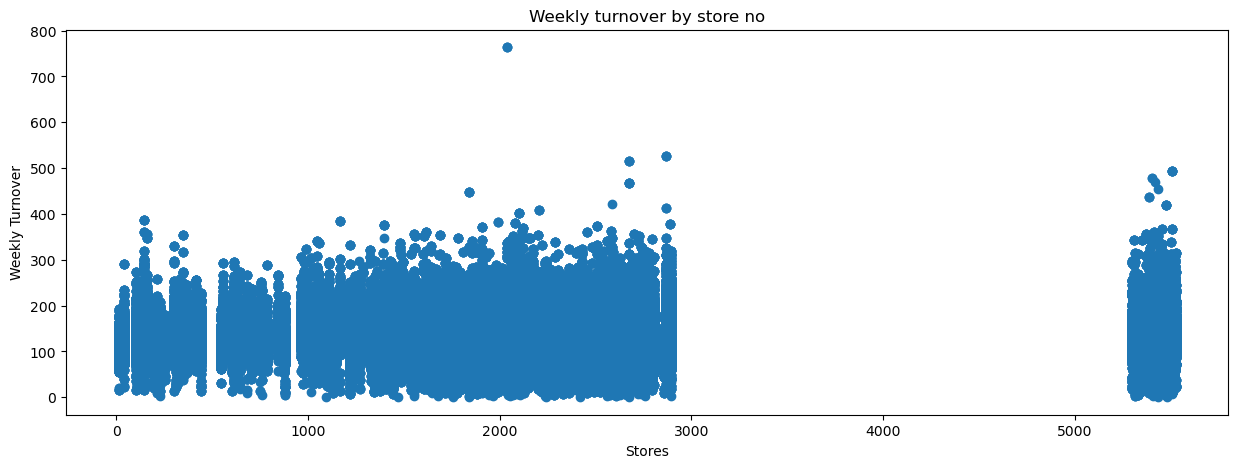

In [397]:
x = df['store_no']
y = df['weekly_turnover_mean']
plt.figure(figsize=(15,5))
plt.title('Weekly turnover by store no')
plt.xlabel('Stores')
plt.ylabel('Weekly Turnover')
plt.scatter(x,y)
plt.show()

In [398]:
df["date"] = pd.to_datetime(df["date"])
df['week'] =df['date'].dt.weekday
df['month'] =df['date'].dt.month 
df['year'] =df['date'].dt.year


df.groupby('month')['turnover'].mean() # to see the best months for sales



month
1      97.320351
2      99.339258
3     110.778544
4     115.533247
5     150.627819
6     180.656797
7     137.012908
8     127.262678
9     146.975187
10    147.850004
11    140.529990
12    137.088098
Name: turnover, dtype: float64

In [399]:
df.groupby('year')['turnover'].mean() # to see the best years for sales


year
2021    135.345180
2022    133.709801
2023    136.333793
Name: turnover, dtype: float64

<Axes: xlabel='month'>

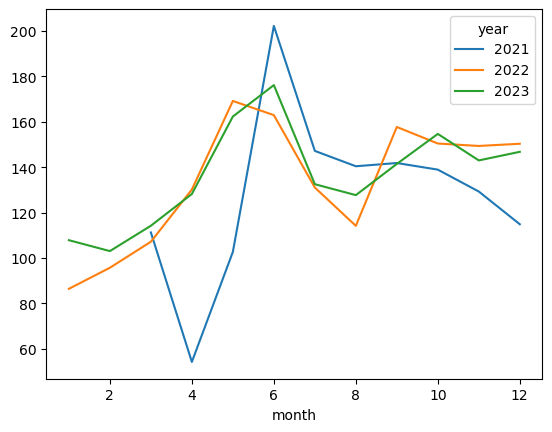

In [400]:
monthly_sales = pd.pivot_table(df, values = "turnover", columns = "year", index = "month")
monthly_sales.plot()

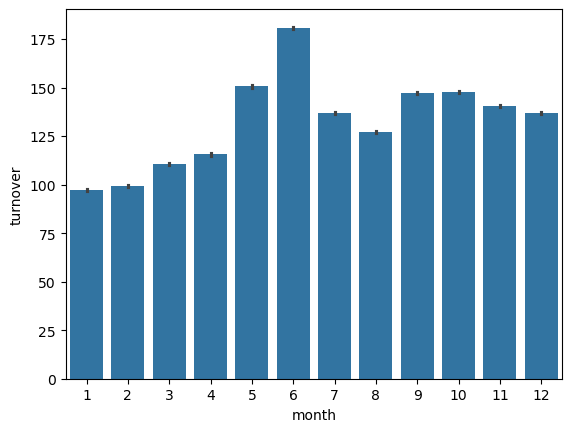

In [401]:
fig = sns.barplot(x='month', y='turnover', data=df)


<Axes: xlabel='avg_temperature'>

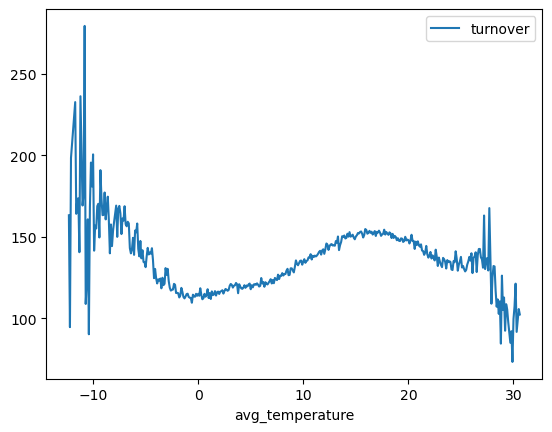

In [402]:
CPI = pd.pivot_table(df, values = "turnover", index= "avg_temperature")
CPI.plot()

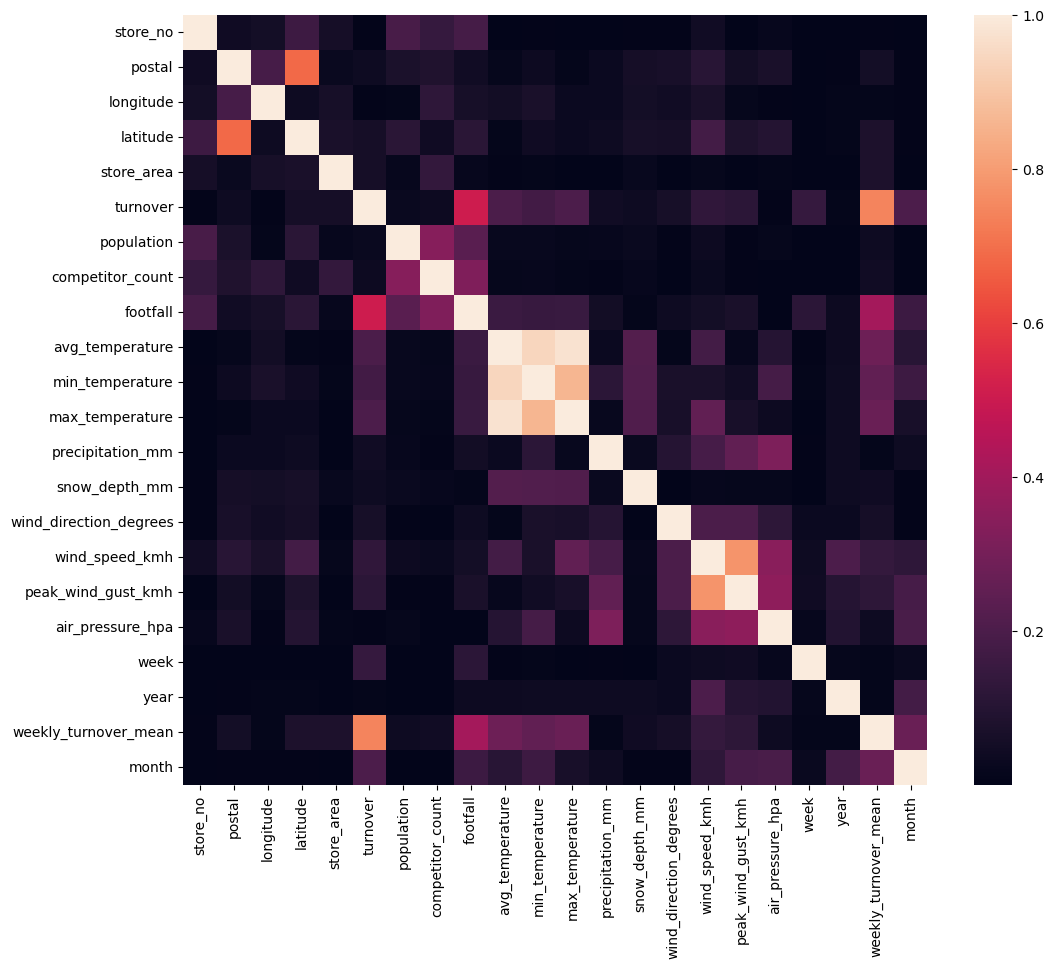

In [403]:
df.to_csv('clean_data.csv')
pd.options.display.max_columns=100
df = pd.read_csv('./clean_data.csv')
df.drop(columns=['Unnamed: 0'],inplace=True)


plt.figure(figsize = (12,10))
numeric_df = df.select_dtypes(include=['number']) 
sns.heatmap(numeric_df.corr().abs())
plt.show()


Index(['date', 'store_no', 'region', 'city', 'postal', 'street', 'longitude',
       'latitude', 'location_type', 'turnover', 'population',
       'competitor_count', 'footfall', 'avg_temperature', 'min_temperature',
       'max_temperature', 'wind_direction_degrees', 'wind_speed_kmh',
       'peak_wind_gust_kmh', 'week', 'year', 'weekly_turnover_mean', 'month'],
      dtype='object')


<Axes: >

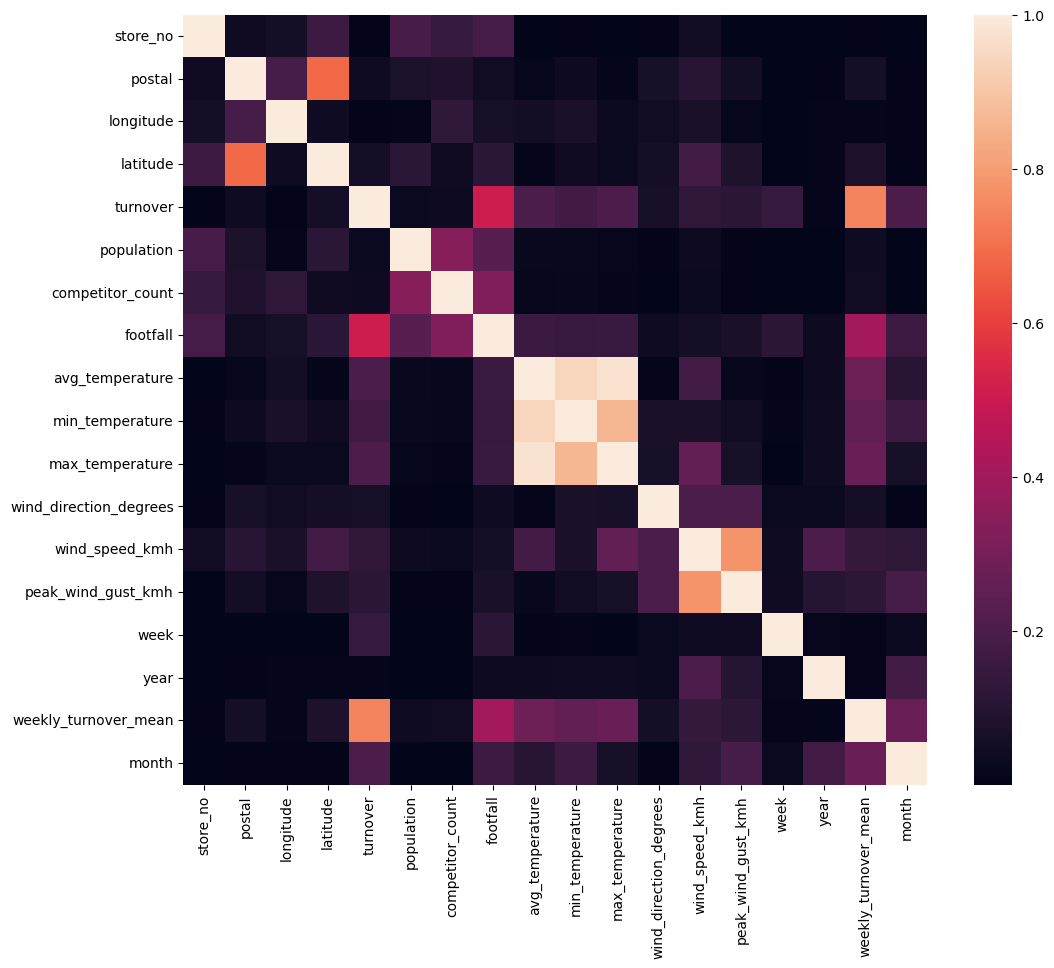

In [404]:
drop_col = [
    'store_area',
    'air_pressure_hpa',
    'precipitation_mm',
    'snow_depth_mm'
]

df.drop(drop_col, axis=1, inplace=True)
print(df.columns)

plt.figure(figsize = (12,10))
numeric_df = df.select_dtypes(include=['number'])  
sns.heatmap(numeric_df.corr().abs())

<Axes: xlabel='avg_temperature'>

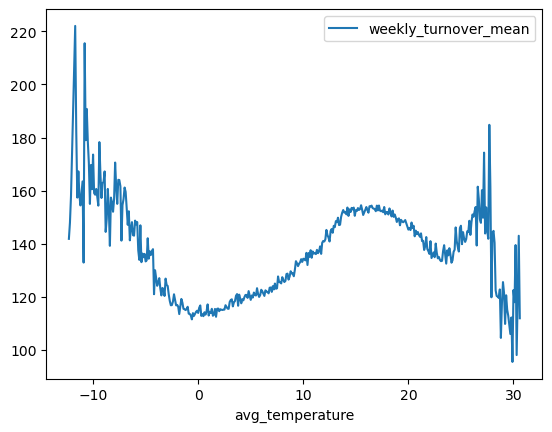

In [405]:
df_new = df.sort_values(by='date', ascending=True)
temp = pd.pivot_table(df, values = "weekly_turnover_mean", index= "avg_temperature")
temp.plot()

<Axes: xlabel='population'>

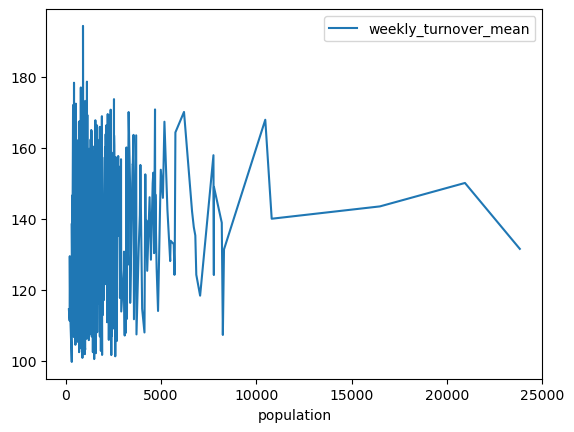

In [406]:
df_new = df.sort_values(by='date', ascending=True)
temp = pd.pivot_table(df, values = "weekly_turnover_mean", index= "population")
temp.plot()

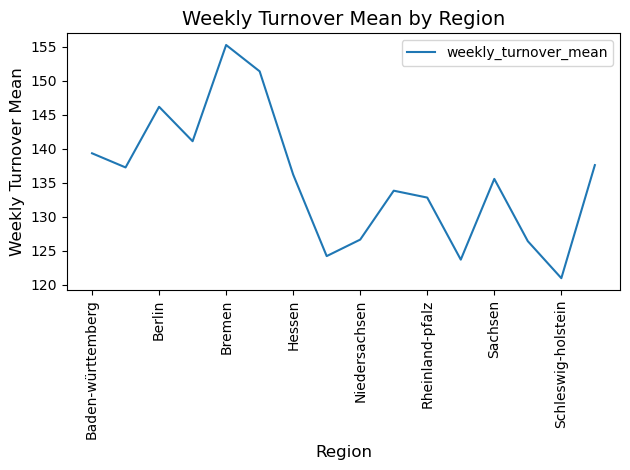

In [407]:
temp = pd.pivot_table(df, values="weekly_turnover_mean", index="region")
temp.plot()

plt.xticks(rotation=90)

plt.title("Weekly Turnover Mean by Region", fontsize=14)
plt.xlabel("Region", fontsize=12)
plt.ylabel("Weekly Turnover Mean", fontsize=12)
plt.tight_layout()
plt.show()


In [408]:
df_new['date'] = pd.to_datetime(df_new['date'])

df_new = df_new[df_new['date'].dt.year == 2023]

print(f"Veri boyutu: {df_new.shape}")
print(f"Başlangıç: {df_new['date'].min()}")
print(f"Bitiş: {df_new['date'].max()}")

Veri boyutu: (151358, 23)
Başlangıç: 2023-01-02 00:00:00
Bitiş: 2023-12-30 00:00:00


In [409]:
train_data = df_new[:int(0.7*(len(df_new)))] 
test_data = df_new[int(0.7*(len(df_new))):] 
target = "weekly_turnover_mean"
used_cols = [c for c in df_new.columns.to_list() if c not in [target]] # all columns except weekly sales

X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [410]:
X = df_new[used_cols] # to keep train and test X values together

In [411]:
X_train = X_train.drop(['date'], axis=1)
X_test = X_test.drop(['date'], axis=1) 
# We have enough information in our date such as week of the year. So, drop date columns.

In [412]:
def wmae_test(test, pred, temperature_data): 
    weights = temperature_data.apply(lambda temp: 5 if temp > 30 else (2 if temp > 20 else 1))  
    error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
    return error

In [413]:
print(X_train.shape)
print(y_train.shape)

(105950, 21)
(105950,)


In [414]:
print("X train:" )
print(X_train.isnull().sum())

print("y train" )
print(y_train.isnull().sum())
print(X_train.dtypes)


X train:
store_no                      0
region                        0
city                          0
postal                        0
street                        0
longitude                     0
latitude                      0
location_type                 0
turnover                      0
population                    0
competitor_count              0
footfall                  43132
avg_temperature               2
min_temperature               3
max_temperature               3
wind_direction_degrees       41
wind_speed_kmh               11
peak_wind_gust_kmh        27324
week                          0
year                          0
month                         0
dtype: int64
y train
0
store_no                    int64
region                     object
city                       object
postal                      int64
street                     object
longitude                 float64
latitude                  float64
location_type              object
turnover                

In [415]:
# Replaces missing values in specific columns 
# using appropriate strategies (median, mode, or a calculated value) 

X_train['footfall'].fillna(X_train['footfall'].median())
X_train['wind_direction_degrees'].fillna(X_train['wind_direction_degrees'].mode()[0])

X_train['peak_wind_gust_kmh'].fillna(X_train['wind_speed_kmh'] * 1.5)


# and then checks how many missing values remain in the dataset.

print(X_train.isnull().sum())

store_no                      0
region                        0
city                          0
postal                        0
street                        0
longitude                     0
latitude                      0
location_type                 0
turnover                      0
population                    0
competitor_count              0
footfall                  43132
avg_temperature               2
min_temperature               3
max_temperature               3
wind_direction_degrees       41
wind_speed_kmh               11
peak_wind_gust_kmh        27324
week                          0
year                          0
month                         0
dtype: int64


In [416]:
# Handles missing values in the training data (X_train) by filling them 
# with specific strategies (median, mode, or calculated values). 

X_train = X_train.fillna({
    'footfall': X_train['footfall'].median(),
    'wind_direction_degrees': X_train['wind_direction_degrees'].mode()[0],
    'peak_wind_gust_kmh': X_train['wind_speed_kmh'] * 1.5
})

# It also performs one-hot encoding (using 0 and 1 values) on categorical columns 
# and converts the training features (X_train) and target values (y_train) into NumPy arrays for model training.

categorical_cols = X_train.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    X_train = pd.get_dummies(X_train, columns=categorical_cols)
    X_test = pd.get_dummies(X_test, columns=categorical_cols)

X_train = X_train.values
y_train = y_train.values


In [417]:
# This code uses GridSearchCV to tune the hyperparameters of a Random Forest Regressor 
# by testing different parameter combinations with 5-fold cross-validation. 
# It trains the model on the training data, selects the best parameters, and evaluates the model on the test data 
# by calculating the Root Mean Squared Error (RMSE) and percentage error. 
# The results, including the best parameters and model performance, are printed.


# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100],       # Number of trees in the forest (100 trees)
    'max_depth': [10],       # Maximum depth of each tree (10 or 15)
    'min_samples_split': [2],  
    'min_samples_leaf': [1] 
}

# Initialize GridSearchCV with RandomForestRegressor and the parameter grid
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    scoring='neg_mean_absolute_error',  # Using negative mean absolute error for evaluation
    cv=5,    # cv = cross-validation
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_)


# Make predictions using the best model from grid search on the test data
y_pred = grid_search.predict(X_test)

# Calculate the Root Mean Squared Error (RMSE) between the actual and predicted values
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate the mean of the actual values (turnover)
mean_turnover = y_test.mean()

# Calculate the percentage error (RMSE as a percentage of the mean turnover)
percent_error = (rmse / mean_turnover) * 100

print(f"\nTest RMSE: {rmse:.2f}")
print(f"Mean Turnover: {mean_turnover:.2f}")
print(f"Percentage Error: {percent_error:.2f}%")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.6min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 3.5min
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 18.078893094148587


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names




Test RMSE: 28.50
Mean Turnover: 147.33
Percentage Error: 19.35%


In [418]:
# Feature Importances
importances = grid_search.best_estimator_.feature_importances_
feat_imp = pd.DataFrame({
   'feature': feature_names,
   'importance': importances
})
feat_imp = feat_imp.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feat_imp.head(10))


Top 10 Most Important Features:
            feature  importance
4          feature5    0.741492
16        feature17    0.124291
14        feature15    0.036532
11        feature12    0.018350
10        feature11    0.011894
8          feature9    0.010549
12        feature13    0.007778
2          feature3    0.005583
9         feature10    0.005400
0   avg_temperature    0.004170


In [419]:
print("\nPrediction Summary Statistics:")
print(results_df.describe())


Prediction Summary Statistics:
             Actual     Predicted  Absolute_Error
count  45408.000000  45408.000000    45408.000000
mean     147.326106    155.475369       23.680114
std       32.083944     27.765401       18.641681
min       56.053610     73.954732        0.001761
25%      124.213830    134.547730        9.234522
50%      144.867020    155.285355       19.573879
75%      168.143920    174.983185       33.910184
max      380.260110    299.259288      254.648574


In [420]:
#import joblib
#joblib.dump(grid_search.best_estimator_, 'random_forest_best_model.pkl')


In [421]:
import matplotlib.pyplot as plt

comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(comparison.head())


           Actual   Predicted
368950  181.00464  160.383451
368949  132.53184  125.813089
368948  112.11596  127.553632
368947  139.08760  124.100847
368946  163.81857  154.346352


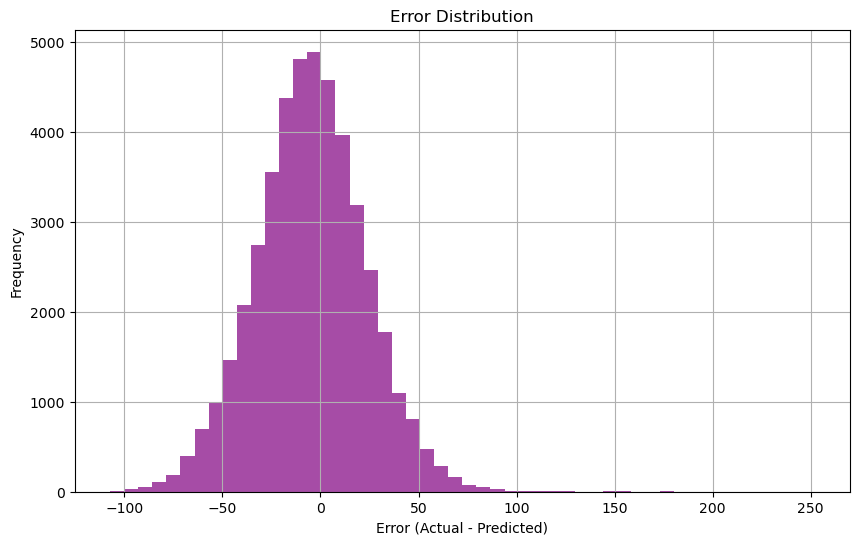

In [422]:
comparison['Error'] = comparison['Actual'] - comparison['Predicted']

plt.figure(figsize=(10, 6))
plt.hist(comparison['Error'], bins=50, color='purple', alpha=0.7)
plt.title('Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid()
plt.show()


           Actual   Predicted
368950  181.00464  160.383451
368949  132.53184  125.813089
368948  112.11596  127.553632
368947  139.08760  124.100847
368946  163.81857  154.346352


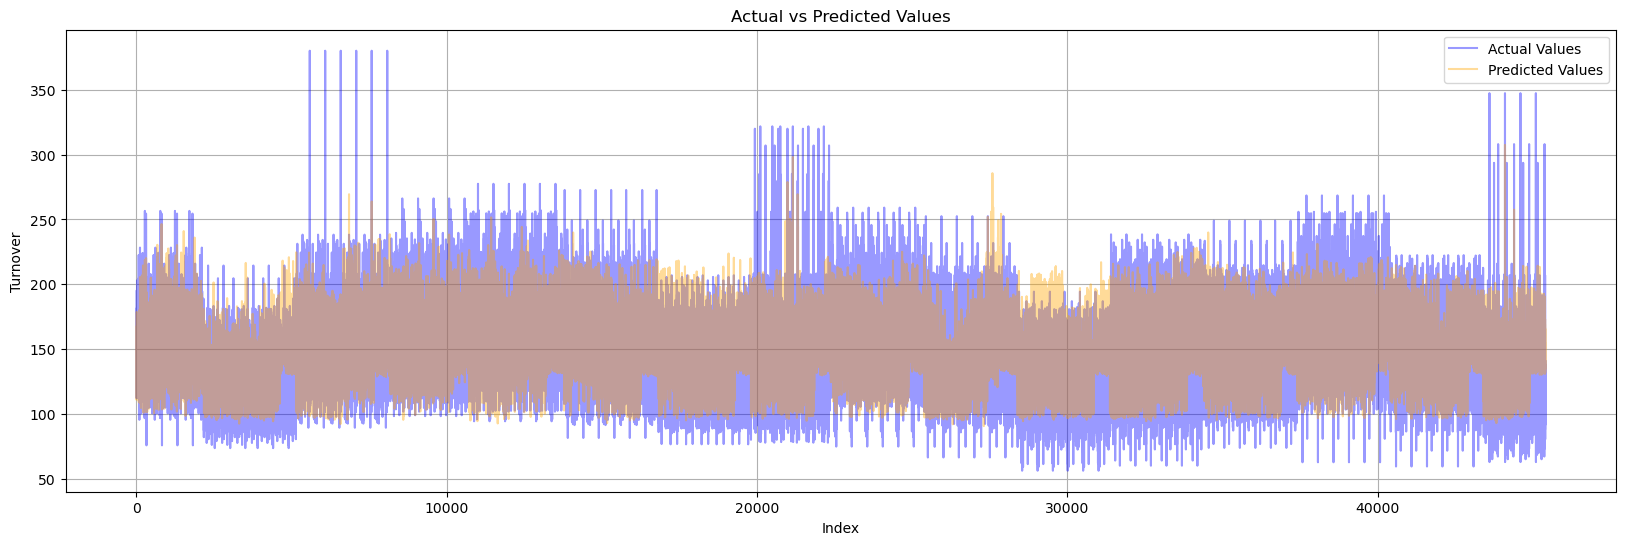

In [423]:
import matplotlib.pyplot as plt
comparison = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})

print(comparison.head())


plt.figure(figsize=(20, 6))
plt.plot(comparison['Actual'].values, label='Actual Values', color='blue', alpha=0.4)
plt.plot(comparison['Predicted'].values, label='Predicted Values', color='orange', alpha=0.4)
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Turnover')
plt.legend()
plt.grid()
plt.show()

In [424]:
def predict_two_weeks_all_stores(model, X_data, start_date):
    unique_stores = np.unique(X_data[:, 0])  

    all_predictions = []
    
    for store in unique_stores:
        store_data = X_data[X_data[:, 0] == store][-1] 
        
        X_pred = np.tile(store_data, (14, 1))
        
        predictions = model.predict(X_pred)
        
        dates = pd.date_range(start=start_date, periods=14, freq='D')
       
        store_predictions = pd.DataFrame({
            'store_no': store,
            'date': dates,
            'predicted_turnover': predictions
        })
        
        all_predictions.append(store_predictions)
    
    # all results
    final_predictions = pd.concat(all_predictions, ignore_index=True)
    return final_predictions


start_date = pd.to_datetime('2015-01-01')
predictions = predict_two_weeks_all_stores(grid_search.best_estimator_, X_train, start_date)

print("\nFirst 3 Predictions:")
pivot_predictions = predictions.pivot(index='date', columns='store_no', values='predicted_turnover')
print(pivot_predictions.head(3))

print("\nSummary Statistics for Predicted Turnover by Store:")
print(predictions.groupby('store_no')['predicted_turnover'].agg(['mean', 'min', 'max', 'std']).round(2))


First 3 Predictions:
store_no          13          42          102         110         123   \
date                                                                     
2015-01-01  153.910054  124.847659  149.642056  117.964759  124.638591   
2015-01-02  153.910054  124.847659  149.642056  117.964759  124.638591   
2015-01-03  153.910054  124.847659  149.642056  117.964759  124.638591   

store_no          132         144         146        160         197   \
date                                                                    
2015-01-01  103.105312  137.258563  140.849545  135.87104  132.648313   
2015-01-02  103.105312  137.258563  140.849545  135.87104  132.648313   
2015-01-03  103.105312  137.258563  140.849545  135.87104  132.648313   

store_no          199         214         227         254         303   \
date                                                                     
2015-01-01  149.094154  148.865058  115.645857  134.829869  147.034905   
2015-01-02  149.094